In [2]:
import os
# os.chdir("../../")

import pandas as pd
import numpy as np

import src.data_processing.MIMIC.data_utils as utils


In [3]:
# Useful variables and definitions
DATA_FD = "data/MIMIC/"
SAVE_FD = DATA_FD + "interim/"
ID_COLUMNS = ["subject_id", "hadm_id", "stay_id"]
TIME_COLUMNS = ["intime", "outtime", "charttime", "deathtime"]
WARDS_TO_REMOVE = ["Unknown", "Emergency Department", "Obstetrics Postpartum",
                   "Obstetrics Antepartum", "Obstetrics (Postpartum & Antepartum)",
                   "Psychiatry", "Labor & Delivery", "Observation", "Emergency Department Observation"]
AGE_LOWERBOUND = 18
PATIENT_INFO = ["gender", "anchor_age", "anchor_year", "dod"]
NEXT_TRANSFER_INFO = ["transfer_id", "eventtype", "careunit", "intime", "outtime"]

TIME_VARS = ["intime", "outtime", "next_intime", "next_outtime", "dod"]
VITALS_NAMING_DIC = {"temperature": "TEMP", "heartrate": "HR", "resprate": "RR",
                     "o2sat": "SPO2", "sbp": "SBP", "dbp": "DBP"}

admission_min_count = 3
vitals_na_threshold = 0.4
resampling_rule = "1H"
admission_min_time_to_outtime = 5
VITALS_TIME_VARS = ["intime", "outtime", "time_to_end_min", "time_to_end_max",
                        "time_to_end", f"sampled_time_to_end({resampling_rule})"]



In [5]:
# Load data

admissions = pd.read_csv(SAVE_FD + "admissions_intermediate.csv", index_col=0, header=0, parse_dates=TIME_VARS)
vitals = pd.read_csv(SAVE_FD + "vitals_intermediate.csv", index_col=0, header=0, parse_dates=VITALS_TIME_VARS)
transfers_core = pd.read_csv(DATA_FD + "core/transfers.csv", index_col=None, header=0,
                             parse_dates=["intime", "outtime"])
vitals = utils.convert_to_timedelta(vitals, f"sampled_time_to_end({resampling_rule})", "time_to_end",
                                    "time_to_end_min",
                                    "time_to_end_max")

In [6]:
# Simple cohort matching
admissions_subset = utils.subsetted_by(admissions, vitals, ["stay_id"])
transfers_subset = utils.subsetted_by(transfers_core, admissions_subset, ["subject_id", "hadm_id"])
vitals["chartmax"] = vitals["outtime"] - vitals["time_to_end"]
vitals["hadm_id"] = admissions.set_index("stay_id").loc[vitals.stay_id.values, "hadm_id"].values


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.97it/s]


In [26]:
from tqdm import tqdm
tqdm.pandas()

counts = vitals.groupby("stay_id").count()
prop_na = vitals.groupby("stay_id").progress_apply(lambda x: x.isna().sum() / x.shape[0])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64164/64164 [04:29<00:00, 238.21it/s]


In [60]:
prop_na

,sampled_time_to_end(1H),TEMP,HR,RR,SPO2,SBP,DBP,time_to_end,stay_id,intime,outtime,time_to_end_min,time_to_end_max,chartmax,hadm_id
stay_id,,,,,,,,,,,,,,,
30000479,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0
30000527,0.0,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0
30000664,0.0,0.866667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.0,0.0,0.0,0.0,0.0,0.666667,0.0
30000666,0.0,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.500000,0.0,0.0,0.0,0.0,0.0,0.500000,0.0
30000685,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39999414,0.0,0.666667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0,0.0,0.0,0.166667,0.0
39999604,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
39999678,0.0,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0


In [80]:
vitals_subset = utils.remove_adms_high_missingness(vitals, ["HR", "RR", "TEMP", "DBP", "SBP", "SPO2"], "stay_id", min_count = 3, min_frac=0.6)

In [73]:
test2 = vitals.groupby("stay_id").progress_apply(lambda x: np.ptp(x["sampled_time_to_end(1H)"]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64164/64164 [00:58<00:00, 1091.73it/s]


In [83]:
vitals_subset.to_csv(SAVE_FD + "vitals_intermediate.csv", index=True, header=True)

In [88]:
admissions_subset = utils.subsetted_by(admissions_subset, vitals_subset, ["stay_id"])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 214.04it/s]


In [100]:
test.max()

Timedelta('0 days 00:45:07.500000')

In [108]:
outcomes = pd.read_csv(DATA_FD + "processed/outcomes_24h_process.csv", index_col=0, header=0)
outcomes.sum(axis=0)

C:\Users\hruia\AppData\Local\Temp\ipykernel_10140\211192336.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  outcomes.sum(axis=0)


De      33
I     1126
W     4684
Di     799
dtype: int64

In [143]:
import src.visualisation.visualisation_utils as vis_utils
import src.visualisation.main as vis_main

from src.data_processing.data_loader import data_loader

import importlib
importlib.reload(vis_main)


<module 'src.visualisation.main' from 'C:\\Users\\hruia\\PycharmProjects\\camelot-icml\\src\\visualisation\\main.py'>


MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6642/6642 [00:27<00:00, 238.40it/s]



MIMIC data successfully loaded.

Basic information 
 Input shape: (6642, 4, 9), (6642, 4) 
 Outcome Distribution: De      55
I     1155
W     3444
Di    1988
dtype: int64
                                   De                      I  \
0                                 0.0                    0.0   
ESI mean                  2.13 ± 0.33            2.14 ± 0.34   
ESI IQR            2.00 (2.00 - 2.00)     2.00 (2.00 - 2.00)   
ESI min-max               2.00 - 3.00            2.00 - 3.00   
age mean                76.71 ± 15.52          63.62 ± 18.78   
age IQR         80.00 (68.50 - 90.00)  66.00 (51.00 - 79.00)   
age min-max             26.00 - 91.00          18.00 - 91.00   
gender mean               0.55 ± 0.50            0.55 ± 0.50   
gender IQR         1.00 (0.00 - 1.00)     1.00 (0.00 - 1.00)   
gender min-max            0.00 - 1.00            0.00 - 1.00   

                                    W                     Di  
0                                 0.0                    0.0

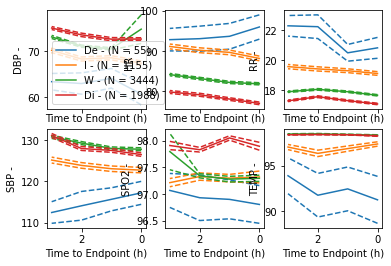

In [144]:
data_info = data_loader(data_name="MIMIC", feat_set="vit-sta", time_range=[0, 4] , target_window=48)

"Visualise Data Properties"
vis_main.visualise_data_groups(data_info)

In [118]:
vitals

,sampled_time_to_end(1H),TEMP,HR,RR,SPO2,SBP,DBP,time_to_end,stay_id,intime,outtime,time_to_end_min,time_to_end_max,chartmax,hadm_id,time_col
0,0 days 00:00:00,98.1,89.0,16.0,99.0,113.0,69.0,0 days 00:28:00,30000479,2136-03-19 08:06:00,2136-03-19 09:02:00,0 days 00:56:00,0 days 00:56:00,2136-03-19 08:34:00,NaN,0.0
1,0 days 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:00:00,30000527,2113-08-19 19:41:00,2113-08-19 21:50:35,0 days 02:05:35,0 days 02:05:35,2113-08-19 21:50:35,28560813.0,0.0
2,0 days 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaT,30000527,2113-08-19 19:41:00,2113-08-19 21:50:35,0 days 02:05:35,0 days 02:05:35,NaT,28560813.0,1.0
3,0 days 02:00:00,98.6,112.0,16.0,100.0,145.0,95.0,0 days 02:05:35,30000527,2113-08-19 19:41:00,2113-08-19 21:50:35,0 days 02:05:35,0 days 02:05:35,2113-08-19 19:45:00,28560813.0,2.0
4,0 days 00:00:00,NaN,74.0,18.0,100.0,138.0,80.0,0 days 00:26:00,30000664,2113-11-21 07:23:00,2113-11-21 22:15:00,0 days 00:52:00,0 days 14:49:00,2113-11-21 21:49:00,24325846.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259013,0 days 00:00:00,NaN,37.0,22.0,100.0,146.0,70.0,0 days 00:19:00,39999863,2122-01-16 18:02:00,2122-01-16 23:01:00,0 days 00:38:00,0 days 04:59:00,2122-01-16 22:42:00,23785188.0,0.0
259014,0 days 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaT,39999863,2122-01-16 18:02:00,2122-01-16 23:01:00,0 days 00:38:00,0 days 04:59:00,NaT,23785188.0,1.0
259015,0 days 02:00:00,NaN,38.0,22.0,100.0,173.0,66.0,0 days 02:00:00,39999863,2122-01-16 18:02:00,2122-01-16 23:01:00,0 days 00:38:00,0 days 04:59:00,2122-01-16 21:01:00,23785188.0,2.0
259016,0 days 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaT,39999863,2122-01-16 18:02:00,2122-01-16 23:01:00,0 days 00:38:00,0 days 04:59:00,NaT,23785188.0,3.0
